# Application à la théorie de l'approximation
Dans cette première partie, on a une fonction $f:\mathbb R^n \rightarrow \mathbb R^q$ qui n'est connue que sur un certain nombre de points $n_{data}$. L'objectif est d'approximer cette fonction $f$ en dehors des points qui sont connus. 

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Neural as Neur

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Première application 
Ici $f$ est une fonction de $[0,1]$ dans $\mathbb{R}$ donnée par 
$x\mapsto \sin(6\pi |x|^{3/2}) +x^2$. Les données d'entrées $x_i$ sont les 256 points répartis uniforméments sur $[0,1]$ et les données de sorties sont les 256 réels donnés par $y_i=f(x_i)$. créez ces données dans un tableau `x` et `y` respectivement.

(1, 256) (1, 256)


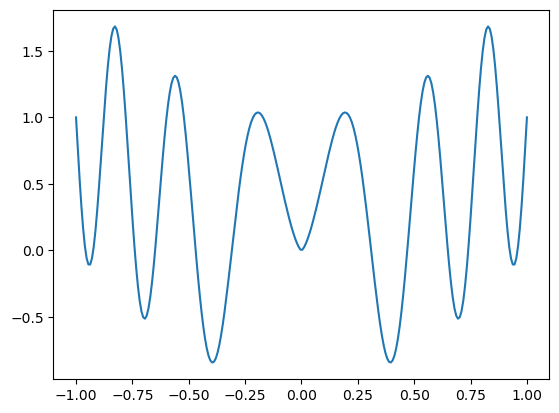

In [11]:
n = 256; # #samples
x = np.linspace(-1,1,n).reshape((1,256))
y = np.sin(6*np.pi*np.abs(x)**1.5) + np.abs(x)**2
print(x.shape,y.shape)
plt.clf
plt.plot(x[0,:], y[0,:]);

La fonction d'activation que nous allons utiliser est la fonction
$$x\mapsto \frac{1}{1+e^{-x}}$$
Implémentez cette fonction d'activation ainsi que sa dérivée dans la classe `Sigmoid`.



In [15]:
import Neural as Neur
L=Neur.Sigmoid()
x2=np.array([0,3,2])
print(L.forward(x2))
print(L.backward(x2))
# Vous devez trouver
# [0.5        0.95257413 0.88079708]
# [0.        , 0.13552998, 0.20998717]


[0.5        0.95257413 0.88079708]
[0.         0.13552998 0.20998717]


# Approximation par réseau de neurones profond
Nous allons construire 2 réseaux de neurones, le premier, noté `N` sera une couche Dense de taille $(1,12)$ suivi d'une sigmoïde et d'une couche dense $(12,1)$. Ce réseau de Neurone sera l'approximation de notre fonction $f$. Nous allons aussi créer un réseau de neurone noté `N_a` qui sera `N` suivi d'une couche de perte en norme $L^2$. Nous nous servirons de `N_a` pour l'optimisation. Créez ces deux réseaux de neurones et utilisez `N_a` pour lancer un algorithme de gradient à pas fixe avec $2000$ itérations, en faisant attention à bien régler le pas (vous verrez c'est quasiment impossible). Votre algorithme doit sortir l'évolution de la fonction objectif le long des itérations. Vous afficherez aussi le plot des vraies données et des prédictions du réseau de Neurone.

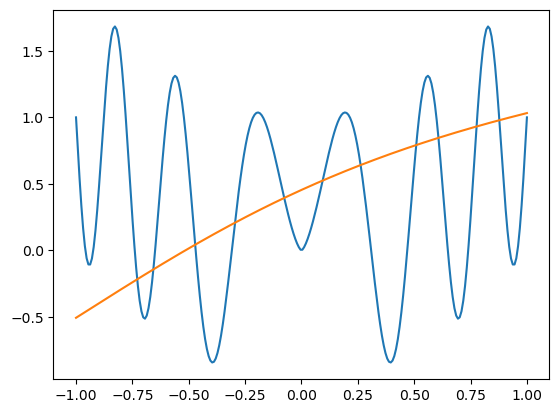

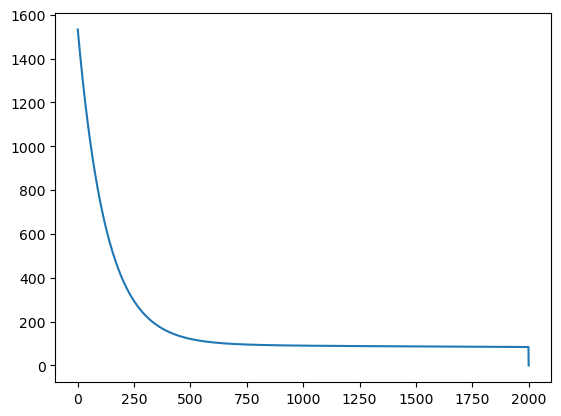

In [33]:
np.random.seed(13)
N_L1 = Neur.Dense(1,12)
N_L2 = Neur.Sigmoid()
N_L3 = Neur.Dense(12,1)
N = Neur.Sequential([N_L1,N_L2,N_L3])
N_a_P = Neur.Loss_L2(y)
N_a = Neur.Sequential([N,N_a_P])
nbiter=2000
step=3.e-6
cost=np.zeros(nbiter+1)
for k in range(nbiter) :
    cost[k] = N_a.forward(x)
    N_a.backward(1)
    for p in N_a.list_params:
        p.data = p.data - step*p.grad
y2=N.forward(x)  
plt.plot(x[0,:],y[0,:])
plt.plot(x[0,:],y2[0,:])
plt.show()
plt.plot(cost)

# Interfaçage avec les librairies de scipy

Normalement vous ne devez pas avoir réussi à trouver le bon pas. Nous allons donc lancer un algorithme d'optimisation de `scipy` qui s'appelle `BFGS` et que vous étudierez l'année prochaine.
Pour fonctionner cet algorithme a besoin de deux fonctions, une qui calcule la fonction en en point et l'autre qui calcule le gradient de la fonction en un point.
Nous allons donc definir plusieurs fonctions

* `Size(N)` : calcule la somme des tailles des paramètres d'un réseau de neurone. On rappelle que si p est un `Parameter`, `p.size` contient la taille de `p` tandis que `p.shape` contient sa forme. 
* `get_data(N)` : rend un vecteur `u` de la taille `Size(n)` qui contient toutes les valeurs de `p.data` pour tous les paramètres `p`
* `get_grad(N)` : rend un vecteur `u` de la taille `Size(n)` qui contient toutes les valeurs de `p.grad` pour tous les paramètres `p`
* `set_data(N,u)` : pour un vecteur `u` de la taille `Size(n)`, parcourt les paramètres et remplit `p.data` en fonction de `u`. C'est la fonction inverse de `get_data(N)`.





In [37]:
np.random.seed(13)
N=Neur.Sequential([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Sequential([N,Neur.Loss_L2(y)])

def Size(N) :
    n=0
    for c in N_a.list_params:
        n += c.size
    return n

def set_data(N_a,u) :
    start = 0
    for c in N_a.list_params:
        size = c.size
        c.data = u[start:start+size].reshape(c.shape)
        start = start + size

def get_data(N_a) :
    data=[]
    for c in N_a.list_params:
        data = np.append(data,c.data.reshape(-1))
    return data

def get_grad(N_a) :
    grad=[]
    for c in N_a.list_params:
        grad = np.append(grad,c.grad.reshape(-1))
    return grad


np.random.seed(13)
u=np.random.randn(Size(N))+2
set_data(N_a,u)
print("test1 : ",[np.linalg.norm(p.data) for p in N_a.list_params])
v=get_data(N_a)
print("test2 : ",np.linalg.norm(u-v))
N_a.forward(x)
N_a.backward(1.)
w=get_grad(N_a)
print("test3 : ",w)
#test1 :  [8.432886918865824, 8.75879733306742, 7.754720583806142, 2.3972413264075336]
#test2 :  0.0
#test3 :  [-1.58333793e+02 -4.29150057e+02 -4.29949903e+01 -3.20344906e+02
# -6.95215743e+02 -2.82456197e+01 -5.15604353e+02 -7.79031007e+02
# -1.56357585e+02 -5.63305866e+01 -1.36982433e+02  1.70383803e+00
#  7.05176030e+02  1.44045763e+03  1.17098516e+02  8.75640465e+02
#  1.87561498e+03  5.52350286e+01  1.16412168e+03  2.31019420e+03
#  9.53127174e+02  3.30728684e+02  6.06008370e+02  2.69677406e+03
#  5.08441853e+03  4.42824217e+03  5.13778456e+03  4.81210824e+03
#  4.53099940e+03  5.35687141e+03  4.77429779e+03  4.54105015e+03
#  3.80967086e+03  5.28674462e+03  5.21662044e+03  3.97303051e+03
#  5.51234177e+03]



test1 :  [8.432886918865822, 8.75879733306742, 7.754720583806142, 2.3972413264075336]
test2 :  0.0
test3 :  [-1.58333793e+02 -4.29150057e+02 -4.29949903e+01 -3.20344906e+02
 -6.95215743e+02 -2.82456197e+01 -5.15604353e+02 -7.79031007e+02
 -1.56357585e+02 -5.63305866e+01 -1.36982433e+02  1.70383803e+00
  7.05176030e+02  1.44045763e+03  1.17098516e+02  8.75640465e+02
  1.87561498e+03  5.52350286e+01  1.16412168e+03  2.31019420e+03
  9.53127174e+02  3.30728684e+02  6.06008370e+02  2.69677406e+03
  5.08441853e+03  4.42824217e+03  5.13778456e+03  4.81210824e+03
  4.53099940e+03  5.35687141e+03  4.77429779e+03  4.54105015e+03
  3.80967086e+03  5.28674462e+03  5.21662044e+03  3.97303051e+03
  5.51234177e+03]


Si vous créez une fonction `func(u)` qui vous calcule le coût pour un paramètre `u` et une fonction `nablafunc(u)` qui vous rend le gradient de la fonction `func`, alors l'algorithme de `BFGS` que nous allons utiliser se lance avec :
`from scipy.optimize import minimize`
`res=minimize(func, u, method='BFGS', jac=nablafunc, options={'gtol': 1e-6, 'disp': True, 'maxiter': 2000})`
Dans le résultat `res`, il y a beaucoup d'information, mais le minimiseur est dans `res.x`.
Le code suivant lance `scipy`, vous devez juste le comprendre.

         Current function value: 0.073809
         Iterations: 2000
         Function evaluations: 2187
         Gradient evaluations: 2187


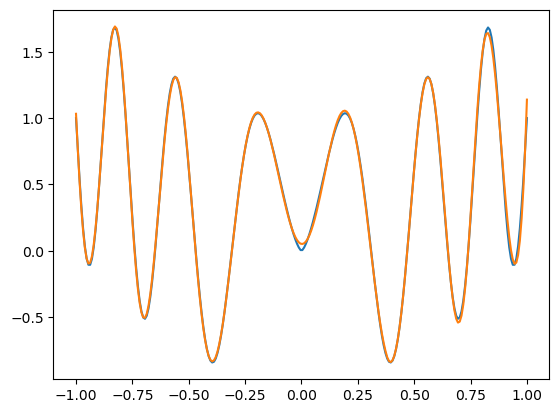

In [38]:
np.random.seed(13)
N=Neur.Sequential([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Sequential([N,Neur.Loss_L2(y)])

def func(u):
    set_data(N_a,u)
    cout = N_a.forward(x)
    return cout

def nablafunc(u):
    set_data(N_a,u)
    N_a.forward(x)
    N_a.backward(1)
    grad = get_grad(N_a)
    return grad

np.random.seed(13)
u=np.random.randn(Size(N_a))

from scipy.optimize import minimize
res = minimize(func, u, method='BFGS', jac=nablafunc, options={'gtol': 1e-6, 'disp': True, 'maxiter': 2000});
u = res.x
set_data(N_a,u)
y2=N.forward(x)
plt.plot(x[0,:],y[0,:])
plt.plot(x[0,:],y2[0,:])
